In [1]:
#! pip install tensorflow

####  Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution that can evaluate images and alert dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

#### Steps:
    Examine and understand data
    Build an input pipeline
    Build the model
    Train the model
    Test the model
    Improve the model and repeat the process

#### Importing all the important libraries

In [2]:
import tensorflow as tf
import numpy as np
import os
import pathlib
import matplotlib.pyplot as plt
import pandas as pd
import os
import PIL

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from glob import glob

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

#### Defining some parameters:

In [3]:
batch_size = 32
img_height = 180
img_width = 180

#### Defining the path for train and test images

In [4]:
train_data = pathlib.Path("Train")
test_data = pathlib.Path('Test')

#### Counting the image files in the train and test images

In [5]:
image_count_train = len(list(train_data.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(test_data.glob('*/*.jpg')))
print(image_count_test)

2239
118


#### Load data using a Keras utility:

#### Doing a validation split. Using 80% of the images for training and 20% for validation.

In [6]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
                                  train_data,
                                  seed=123,
                                  validation_split = 0.2,
                                  subset = 'training',
                                  image_size=(img_height, img_width),
                                  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    train_data,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


#### Listing all the classes of skin cancer and store them in a list

In [8]:
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


#### Visualize the data:

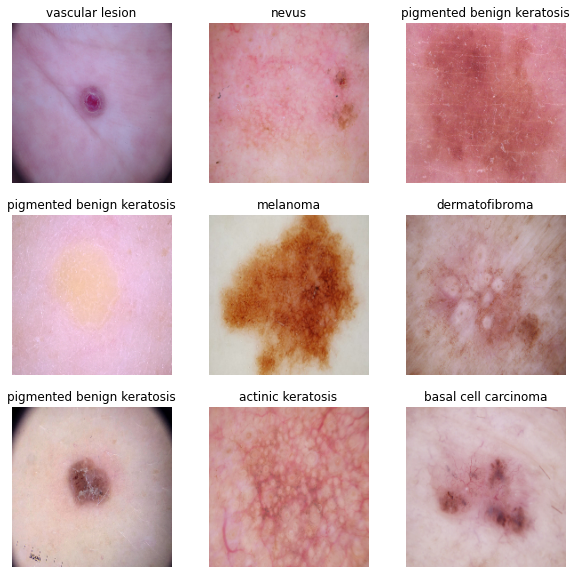

In [9]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

#### Above displayed are the first nine images from the training dataset

In [10]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#### Standardize the data:

In [12]:
normalization_layer = layers.Rescaling(1./255)

In [13]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# The pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.07254902 0.87696075


#### Create the model:

In [14]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

#### Compile the model:

In [15]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### Summary of all layers:

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

#### Training the model for 20 epochs:

In [17]:
epochs = 20
history = model.fit(
                      train_ds,
                      validation_data = val_ds,
                      epochs=epochs
                    )

Epoch 1/20
56/56 [==============================] - 130s 2s/step - loss: 1.9831 - accuracy: 0.2762 - val_loss: 1.6803 - val_accuracy: 0.3960
Epoch 2/20
56/56 [==============================] - 117s 2s/step - loss: 1.6109 - accuracy: 0.4364 - val_loss: 1.4584 - val_accuracy: 0.5011
Epoch 3/20
56/56 [==============================] - 119s 2s/step - loss: 1.4256 - accuracy: 0.5061 - val_loss: 1.4310 - val_accuracy: 0.4899
Epoch 4/20
56/56 [==============================] - 118s 2s/step - loss: 1.3414 - accuracy: 0.5290 - val_loss: 1.4688 - val_accuracy: 0.5145
Epoch 5/20
56/56 [==============================] - 118s 2s/step - loss: 1.3145 - accuracy: 0.5536 - val_loss: 1.4476 - val_accuracy: 0.5056
Epoch 6/20
56/56 [==============================] - 117s 2s/step - loss: 1.2440 - accuracy: 0.5686 - val_loss: 1.5271 - val_accuracy: 0.4743
Epoch 7/20
56/56 [==============================] - 118s 2s/step - loss: 1.1775 - accuracy: 0.5781 - val_loss: 1.4031 - val_accuracy: 0.5257
Epoch 8/20
56

#### Visualizing training results:

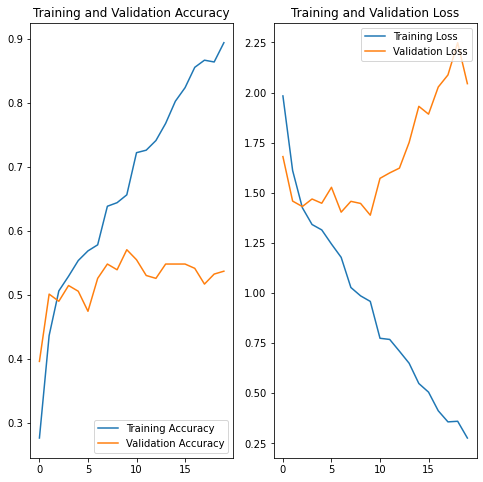

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### The plots show that training accuracy and validation accuracy are off by large margins, and the model has achieved only around 50% accuracy on the validation set.

#### Overfitting:

    In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 50% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable. This is a sign of overfitting.
    To deal with over fitting, we will use data augmentation.

In [19]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

#### Applying data augmentation to the same image several times & visualizing it:

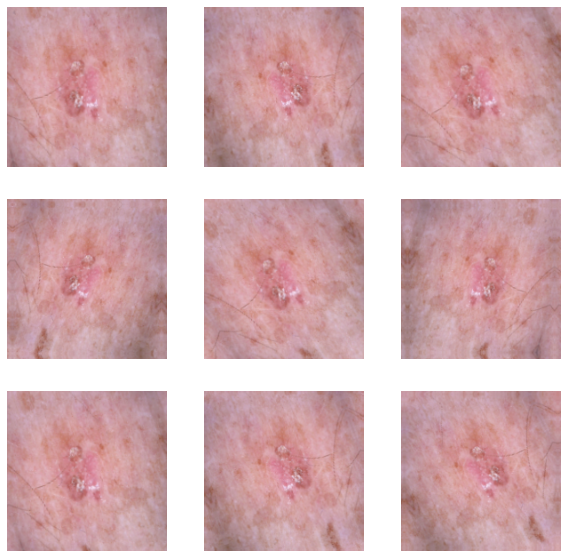

In [20]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")


#### Creating the new model with augmented data.

In [21]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

#### Compiling the model:

In [22]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### Viewing model summary:

In [23]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

#### Training the model with 20 epochs

In [24]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 169s 3s/step - loss: 1.8196 - accuracy: 0.3287 - val_loss: 1.6776 - val_accuracy: 0.4116
Epoch 2/20
56/56 [==============================] - 136s 2s/step - loss: 1.5212 - accuracy: 0.4782 - val_loss: 1.5061 - val_accuracy: 0.5101
Epoch 3/20
56/56 [==============================] - 147s 3s/step - loss: 1.4670 - accuracy: 0.4721 - val_loss: 1.4993 - val_accuracy: 0.5056
Epoch 4/20
56/56 [==============================] - 144s 3s/step - loss: 1.3712 - accuracy: 0.5117 - val_loss: 1.3854 - val_accuracy: 0.5280
Epoch 5/20
56/56 [==============================] - 148s 3s/step - loss: 1.3293 - accuracy: 0.5329 - val_loss: 1.5235 - val_accuracy: 0.4989
Epoch 6/20
56/56 [==============================] - 145s 3s/step - loss: 1.3089 - accuracy: 0.5407 - val_loss: 1.3273 - val_accuracy: 0.5324
Epoch 7/20
56/56 [==============================] - 149s 3s/step - loss: 1.3098 - accuracy: 0.5368 - val_loss: 1.3588 - val_accuracy: 0.5302
Epoch 8/20
56

#### Visualizing the Accuracy on training amd validation data:

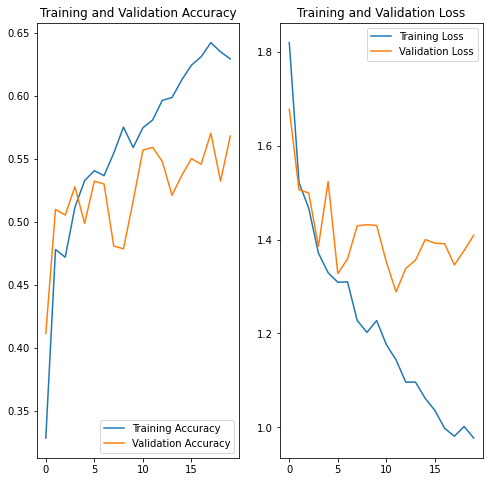

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Here we can see that training and validation accuracy are almost travelling the same path. Thus, we have managed to handle the overfitting.

#### Class distribution: Examining the current class distribution in the training dataset:

In [26]:
num_classes = 9

@tf.function
def count_class(counts, batch):
    y, _, c = tf.unique_with_counts(batch[1])
    return tf.tensor_scatter_nd_add(counts, tf.expand_dims(y, axis=1), c)

counts = train_ds.reduce(
    initial_state=tf.zeros(num_classes, tf.int32),
    reduce_func=count_class)
print(class_names)
print(counts.numpy())

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
[ 92 309  77 352 277 370  58 142 115]


#### Which class has the least number of samples?
    Seborrheic keratosis has the least number of samples i.e. 58 samples.
#### Which classes dominate the data in terms of the proportionate number of samples?
    Pigmented benign keratosis dominate the data that contains 370 samples.

In [27]:
!pip install Augmentor

#### Treating class imbalance:

In [28]:
training_ds_path="Train/"
import Augmentor

In [29]:
for i in class_names:
    p = Augmentor.Pipeline(training_ds_path + i)
    p.rotate(probability = 0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the c

Initialised with 114 image(s) found.
Output directory set to Train/actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x29180423070>: 100%|█| 500/500 [00:17<00:00, 27.95 Samples/


Initialised with 376 image(s) found.
Output directory set to Train/basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x291806D7EE0>: 100%|█| 500/500 [00:17<00:00, 28.28 Samples/


Initialised with 95 image(s) found.
Output directory set to Train/dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x291803CD7C0>: 100%|█| 500/500 [00:18<00:00, 26.87 Samples/


Initialised with 438 image(s) found.
Output directory set to Train/melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x291E6A26FA0>: 100%|█| 500/500 [01:41<00:00,  4.91 Samples


Initialised with 357 image(s) found.
Output directory set to Train/nevus\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x29180071070>: 100%|█| 500/500 [01:23<00:00,  5.97 Samples/


Initialised with 462 image(s) found.
Output directory set to Train/pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x291A4A77CD0>: 100%|█| 500/500 [00:17<00:00, 28.30 Samples/


Initialised with 77 image(s) found.
Output directory set to Train/seborrheic keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x291E164A4F0>: 100%|█| 500/500 [00:45<00


Initialised with 181 image(s) found.
Output directory set to Train/squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x291AE4533A0>: 100%|█| 500/500 [00:18<00:00, 27.63 Samples/


Initialised with 139 image(s) found.
Output directory set to Train/vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x291E6A26160>: 100%|█| 500/500 [00:20<00:00, 24.90 Samples/


#### Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [30]:
image_count_train = len(list(train_data.glob('*/output/*.jpg')))
print(image_count_train)

4500


#### Training the model on the data created using Augmentor:

In [35]:
batch_size = 32
img_height = 180
img_width = 180

In [36]:
train_data="Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
                                  train_data,
                                  seed=123,
                                  validation_split = 0.2,
                                  subset = 'training',
                                  image_size=(img_height, img_width),
                                  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [37]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
                                  train_data,
                                  seed=123,
                                  validation_split = 0.2,
                                  subset = 'validation',
                                  image_size=(img_height, img_width),
                                  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [38]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


In [39]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [40]:
normalization_layer = layers.Rescaling(1./255)

In [41]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.12810452 0.73823535


#### Model Creation:

In [42]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

#### Compiling the model:

In [43]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### Viewing the model summary:

In [44]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 45, 45, 64)       

#### Training the model with 30 epochs:

epochs = 30
history = model.fit(
                      train_ds,
                      validation_data = val_ds,
                      epochs=epochs
                    )

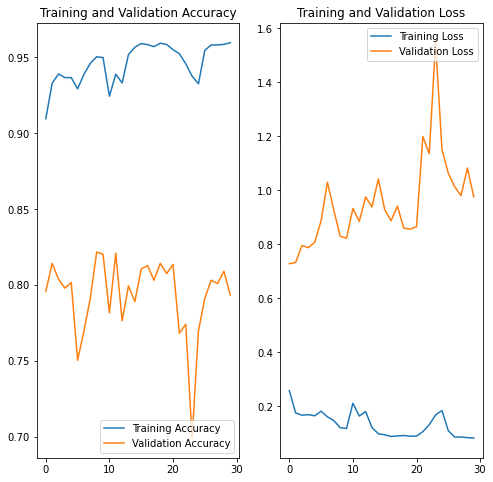

In [47]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Here we can see that the training accuracy is above 90% and validation accuracy is around 80% which is relatively good from the other two models created previously. 